In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.transforms import Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, Resize
import os
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from tqdm import tqdm
import cv2

In [19]:
device = torch.device("cuda:0")

In [20]:
dirCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_COVID'
dirNonCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_NonCOVID'

In [21]:
class CTCOVIDDataset(Dataset):

    def __init__(self, dirCOVID, dirNonCOVID, transforms, data):
        self.IMG_SIZE = 224
        self.valSplit = 0.1
        self.COVID = dirCOVID
        self.NonCOVID = dirNonCOVID
        self.LABELS = {self.NonCOVID:0, self.COVID:1}
        self.training_data = []
        
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                path = os.path.join(label, f)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), self.LABELS[label]])
                
        np.random.shuffle(self.training_data)
        self.valSize = int(self.valSplit*len(self.training_data))
        
        self.X_val = torch.Tensor([i[0] for i in self.training_data[0:self.valSize]]).view(-1, 3, 224, 224)
        self.X_val/=255
        self.y_val = torch.Tensor([i[1] for i in self.training_data[0:self.valSize]])
        
        self.X_test = torch.Tensor([i[0] for i in self.training_data[self.valSize: self.valSize+self.valSize]]).view(-1, 3, 224, 224)
        self.X_test/=255
        self.y_test = torch.Tensor([i[1] for i in self.training_data[self.valSize: self.valSize+self.valSize]])
        
        self.X_train = torch.Tensor([i[0] for i in self.training_data[self.valSize+self.valSize:]]).view(-1, 3, 224, 224)
        self.X_train/=255
        self.y_train = torch.Tensor([i[1] for i in self.training_data[self.valSize+self.valSize:]])
        
        self.transforms = transforms
        self.data = data

    def __len__(self):
        
        if self.data == 'train':
            return self.y_train.shape[0]
        elif self.data == 'val':
            return self.y_val.shape[0]
        elif self.data == 'test':
            return self.y_test.shape[0]

    def __getitem__(self, idx):
        
        if self.data == 'train':
            return self.X_train[idx], self.y_train[idx]
        elif self.data == 'val':
            return self.X_val[idx], self.y_val[idx]
        elif self.data == 'test':
            return self.X_test[idx], self.y_test[idx]


In [22]:
#Tune the transforms
train_transforms = transforms.Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(degrees=15, prob=0.5),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    Resize(spatial_size=(224, 224)),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [23]:
train_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = train_transforms, data = 'train')
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True) #Tune batch size

val_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'val')
val_loader = DataLoader(val_ds, batch_size=20, shuffle=True)

test_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'test')
test_loader = DataLoader(test_ds, batch_size=20, shuffle=True)

100%|██████████| 346/346 [00:01<00:00, 328.84it/s]


In [24]:
print(train_ds.__len__())
print(val_ds.__len__())
print(test_ds.__len__())

595
74
74


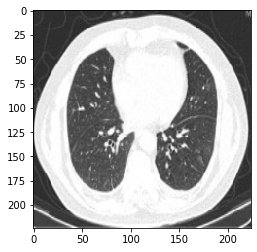

In [25]:
img1 = 0
for batch in train_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

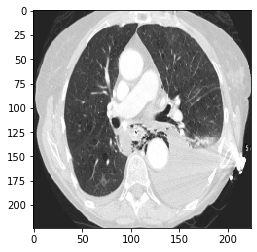

In [26]:
img2 = 0
for batch in val_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

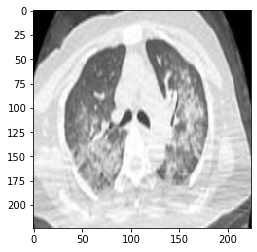

In [27]:
img = 0
for batch in test_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

In [28]:
def validation(model, val_loader, criterion):
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(val_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        
        for index, i in enumerate(output):
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    return test_loss, accuracy

In [29]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        total = 0
        correct = 0
        train_loss = 0
        for data in tqdm(train_loader):
            X, y = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y.long())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            for index, i in enumerate(output):
                if torch.argmax(i) == y[index]:
                    correct+=1
                total+=1
                
        model.eval()
                
        with torch.no_grad():
            val_loss, val_acc = validation(model, val_loader, criterion)
                    
                
        print("Training Loss:", train_loss)
        print("Training Accuracy:", correct/total)
        print("Validation Loss:", val_loss)
        print("Validation Accuracy:", val_acc)

        model.train()
        

In [34]:
model = torchvision.models.vgg16(pretrained = True).to(device)
#model = torchvision.models.densenet121(pretrained = True).to(device)
#model = torchvision.models.resnet50(pretrained = True).to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [35]:
for param in model.parameters():
    param.requires_grad = False

#Tune the number of hidden layers, hidden units, kernel_initializer, add batch norm
'''
VGG16 model classifier layers
'''
layers = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 512)),
    ('activation1', nn.ReLU()),
    ('dropout1', nn.Dropout()),
    ('fc2', nn.Linear(512, 256)),
    ('activation2', nn.ReLU()),
    ('dropout2', nn.Dropout()),
    ('fc3', nn.Linear(256, 128)),
    ('activation3', nn.ReLU()),
    ('dropout3', nn.Dropout()),
    ('fc4', nn.Linear(128, 2)),
    ('out', nn.Sigmoid())
    
])).to(device)

model.classifier = layers


'''
ResNet model classifier layers

layers = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 512)),
     ('activation1', nn.ReLU()),
     ('fc2', nn.Linear(512, 2)),
     ('output', nn.Sigmoid())])).to(device)
model.fc = layers
'''

optimizer = optim.Adam(model.parameters()) #Tune the learning rate
criterion = nn.CrossEntropyLoss()

train(model, train_loader, val_loader, optimizer, criterion, 10)

  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 21.197223901748657
Training Accuracy: 0.5277310924369748
Validation Loss: 2.747346580028534
Validation Accuracy: 0.4864864864864865


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 20.393260717391968
Training Accuracy: 0.5966386554621849
Validation Loss: 2.724871873855591
Validation Accuracy: 0.5540540540540541


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 19.207084119319916
Training Accuracy: 0.6369747899159663
Validation Loss: 2.828728675842285
Validation Accuracy: 0.5675675675675675


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 17.818329751491547
Training Accuracy: 0.6840336134453782
Validation Loss: 2.3895079493522644
Validation Accuracy: 0.7027027027027027


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 16.79411619901657
Training Accuracy: 0.7378151260504202
Validation Loss: 2.8905574083328247
Validation Accuracy: 0.581081081081081


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 17.33450338244438
Training Accuracy: 0.7176470588235294
Validation Loss: 2.5048444271087646
Validation Accuracy: 0.6621621621621622


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 15.419114232063293
Training Accuracy: 0.7983193277310925
Validation Loss: 2.2774729132652283
Validation Accuracy: 0.7432432432432432


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 14.808518826961517
Training Accuracy: 0.8100840336134454
Validation Loss: 2.209478050470352
Validation Accuracy: 0.7432432432432432


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 14.187723636627197
Training Accuracy: 0.8436974789915966
Validation Loss: 2.245926946401596
Validation Accuracy: 0.7297297297297297


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

Training Loss: 13.83311527967453
Training Accuracy: 0.8470588235294118
Validation Loss: 2.1088127493858337
Validation Accuracy: 0.7702702702702703
